In [86]:
import os
import psycopg2
from dotenv import load_dotenv
from sshtunnel import SSHTunnelForwarder
import time
import pandas as pd
import numpy as np
import statsmodels
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [87]:
# Load environment variables from .env file
load_dotenv("environment_variables.env")
psql_pw = os.getenv("PSQL_PW")

# Get data
## DB Connection

In [88]:
# Connect to AWS RDS instance through AWS EC2 instance

# SSH parameters
bastion_host = 'ec2-34-224-93-62.compute-1.amazonaws.com'
bastion_user = 'ec2-user'
# bastion_key = 'C:\\Users\\detto\\Documents\\ec2-key-pair.pem'
bastion_key = "/Users/adettor/Documents/YouTubeViewPrediction/ec2-key-pair.pem"

# RDS parameters
rds_host = 'youtubeviewprediction.cd0c8oow2pnr.us-east-1.rds.amazonaws.com'
rds_user = 'postgres'
rds_password = psql_pw
rds_database = 'YouTubeViewPrediction'
rds_port = 5432

try:
    # Create an SSH tunnel
    tunnel = SSHTunnelForwarder(
        (bastion_host, 22),
        ssh_username=bastion_user,
        ssh_pkey=bastion_key,
        remote_bind_address=(rds_host, rds_port),
        local_bind_address=('localhost', 6543)  # Choose a local port for the tunnel
    )

    # Start the tunnel
    tunnel.start()

    # Connect to PostgreSQL through the tunnel
    conn = psycopg2.connect(
        database=rds_database,
        user=rds_user,
        password=rds_password,
        host=tunnel.local_bind_host,
        port=tunnel.local_bind_port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a SQL query
    cursor.execute("SELECT version();")

    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record)

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL:", error)

You are connected to -  ('PostgreSQL 16.1 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 7.3.1 20180712 (Red Hat 7.3.1-12), 64-bit',)


## Turn SQL tables in to Pandas dataframes

In [89]:
video_fact = pd.read_sql_query("SELECT * FROM video_fact", conn)
video_dim = pd.read_sql_query("SELECT * FROM video_dim", conn)
channel_fact = pd.read_sql_query("SELECT * FROM channel_fact", conn)
channel_dim = pd.read_sql_query("SELECT * FROM channel_dim", conn)
categories_dim = pd.read_sql_query("SELECT * FROM categories_dim", conn)

In [90]:
conn.close()
cursor.close()
tunnel.stop()

# EDA
## video_fact

In [91]:
video_fact.shape

(102763, 5)

In [92]:
video_fact.dtypes

collected_at    datetime64[ns]
video_id                object
num_views                int64
num_likes                int64
num_comments             int64
dtype: object

In [93]:
video_fact.describe()

,collected_at,num_views,num_likes,num_comments
count,102763,1.027630e+05,1.027630e+05,102763.000000
mean,2024-08-03 15:07:49.430786304,2.927422e+06,1.118557e+05,7361.192939
min,2024-07-20 21:00:06.211863,3.034000e+04,0.000000e+00,0.000000
25%,2024-07-30 00:00:06.181241088,5.052275e+05,1.325300e+04,1012.000000
50%,2024-08-04 12:00:05.796592896,9.960610e+05,3.192600e+04,2428.000000
75%,2024-08-08 21:00:05.966454016,2.102045e+06,7.754150e+04,4981.000000
max,2024-08-12 12:00:05.915433,2.213997e+08,8.358441e+06,385935.000000
std,NaN,1.130190e+07,5.053384e+05,28068.962104


Some videos have 0 likes and/or 0 comments

In [94]:
video_fact[["collected_at", "video_id"]].nunique()

collected_at    182
video_id        948
dtype: int64

In [95]:
video_fact.isna().sum()

collected_at    0
video_id        0
num_views       0
num_likes       0
num_comments    0
dtype: int64

### video_id

In [96]:
id_counts = video_fact["video_id"].value_counts()
id_counts

video_id
laNA2HgwYXU    182
6CXWUjjcQxg    182
j7YgKocz2W4    182
O_A8HdCDaWM    182
P1jGg5nMoyc    182
              ... 
c3dRiSdVSd0      1
mmnf2dHPz04      1
5yZ8hFu92WE      1
SE4fuVbVkPg      1
jcB7QA5N7CE      1
Name: count, Length: 948, dtype: int64

Text(0, 0.5, 'Number of Time Points Collected')

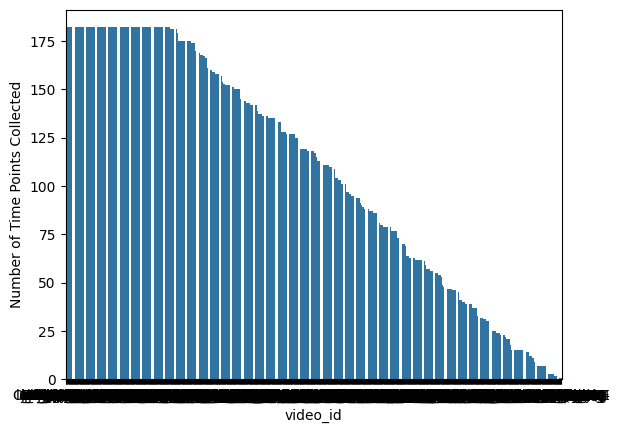

In [97]:
ax = sns.barplot(x=id_counts.index, y=id_counts)
ax.set_ylabel("Number of Time Points Collected")

In [98]:
id_counts2 = id_counts.value_counts()
id_counts2.sort_index(inplace=True, ascending=False)
id_counts2

count
182    200
181     13
179      1
177      1
175     24
      ... 
6        2
5        1
3       12
2        9
1        5
Name: count, Length: 114, dtype: int64

Text(0, 0.5, 'Number of Videos')

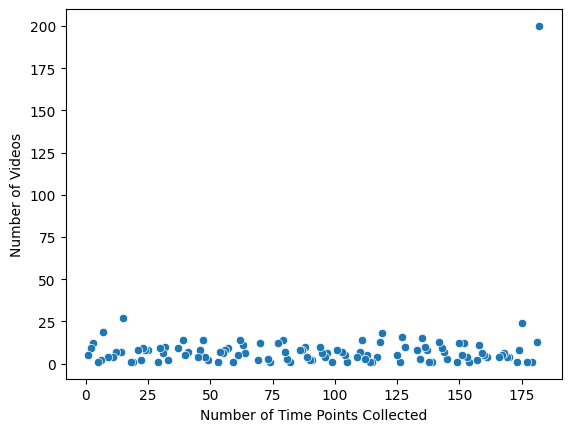

In [99]:
ax = sns.scatterplot(x=id_counts2.index, y=id_counts2)
ax.set_xlabel("Number of Time Points Collected")
ax.set_ylabel("Number of Videos")

In [100]:
ids = id_counts.sample(15).index
print(ids)

Index(['uO4t4adlUYQ', 'Ifs6oppE858', 'CW5oaChLgyE', 'XRh1_IVW8y0',
       'Q7qXMrdy1Sw', 'KoH4RcdNUoU', 'vEhYTJpC2No', 'UmJphrg_tfg',
       '7VJOP99t1Pw', 'nEP-_Ogi1bA', 'pBM2xyco_Kg', 'U8UYgoKneCo',
       'y-A2HgDXzks', 'kQkYabjDIrM', 'wAzEJxOo1ts'],
      dtype='object', name='video_id')


### num_views

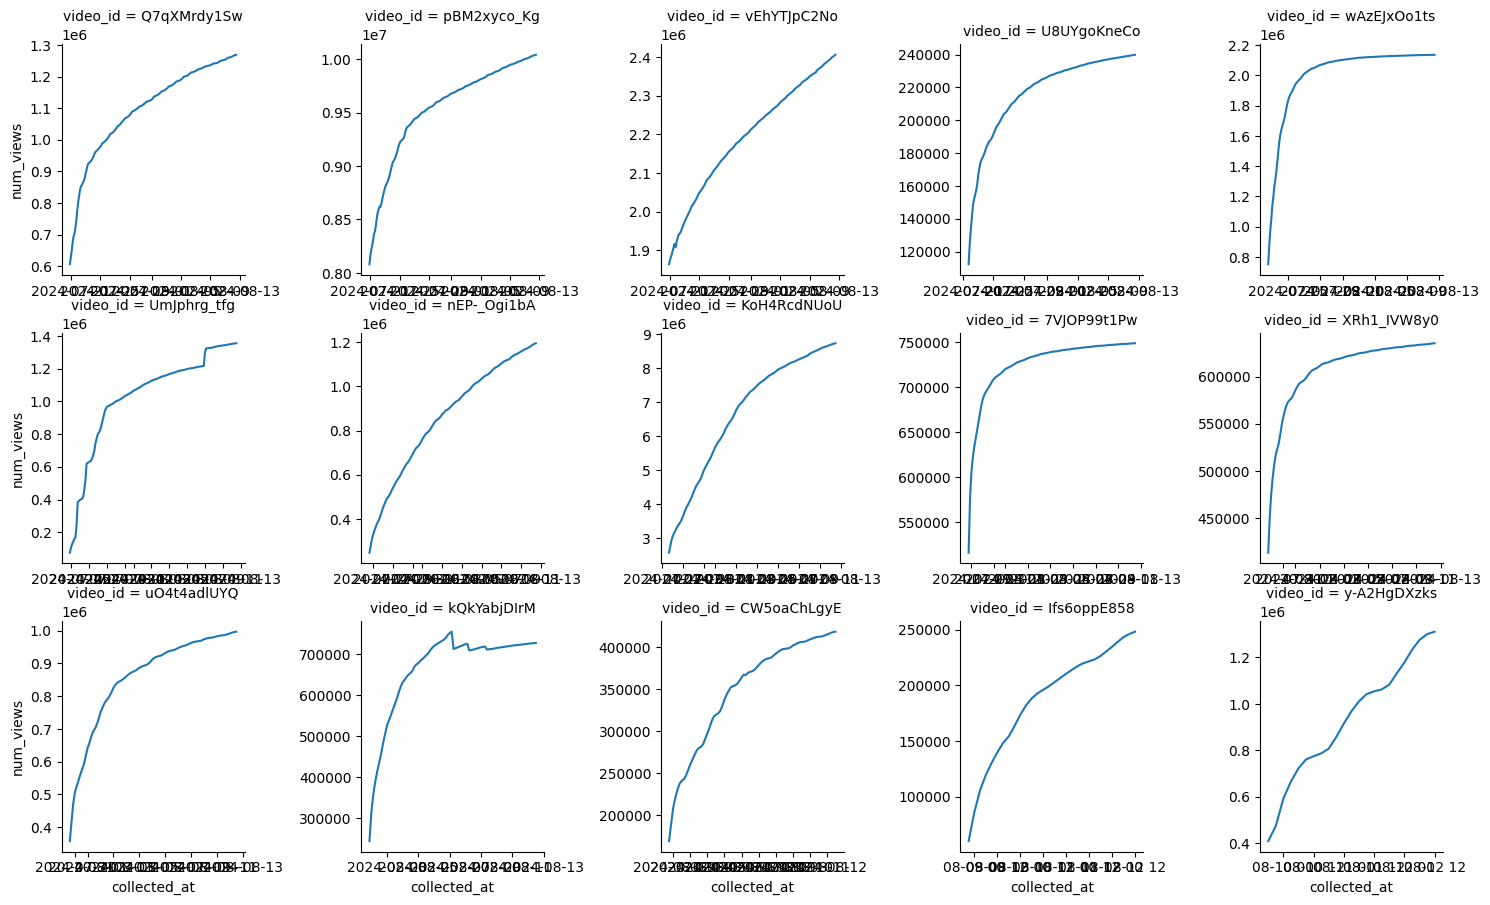

In [101]:
col = "num_views"
id_data = video_fact.loc[video_fact["video_id"].isin(ids), ["video_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="video_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_comments

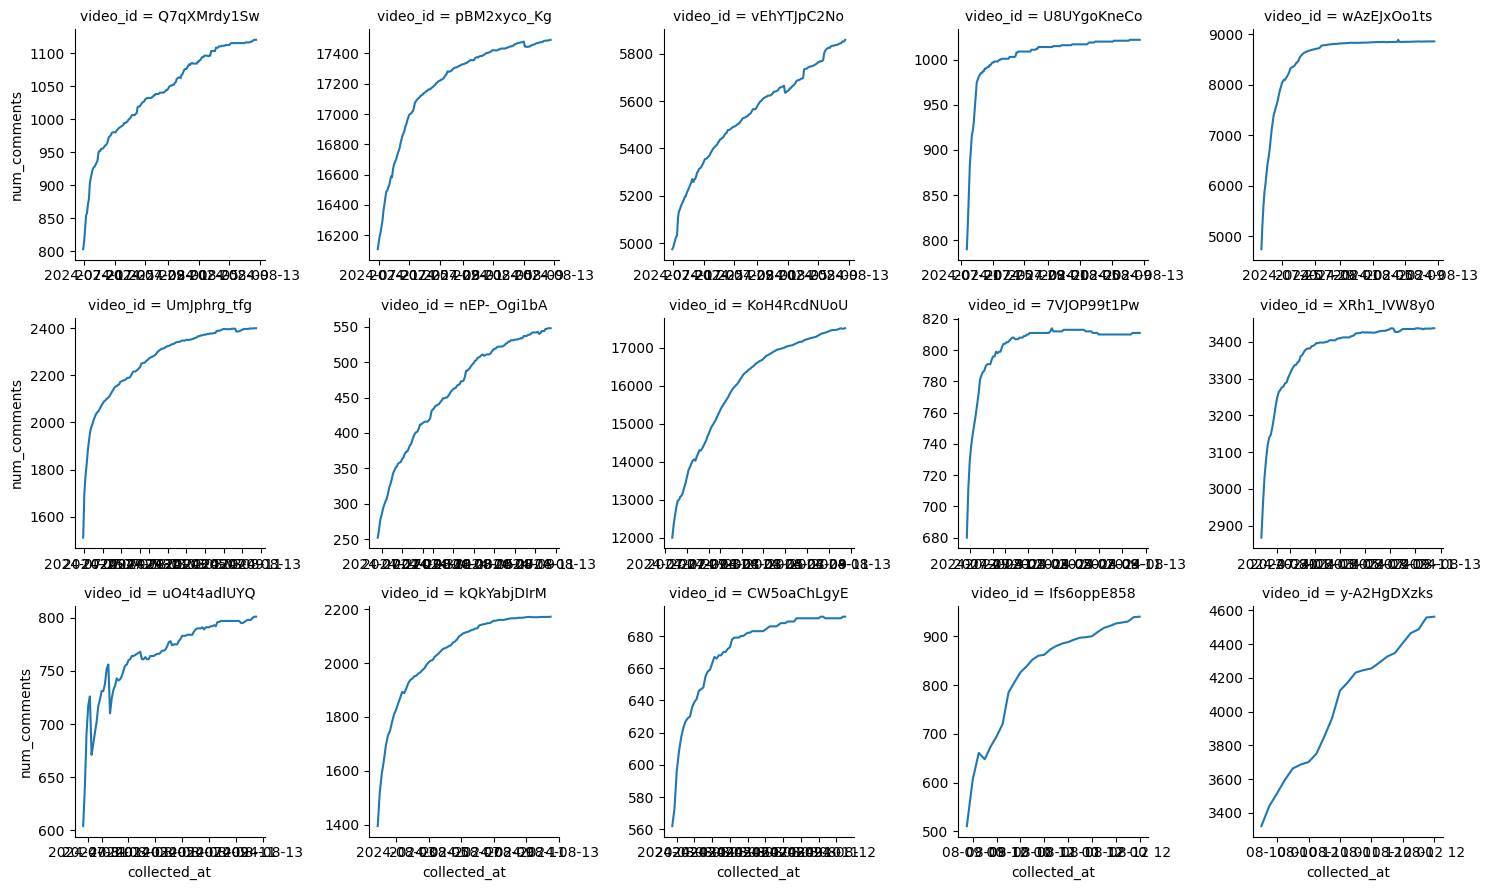

In [102]:
col = "num_comments"
id_data = video_fact.loc[video_fact["video_id"].isin(ids), ["video_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="video_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_likes

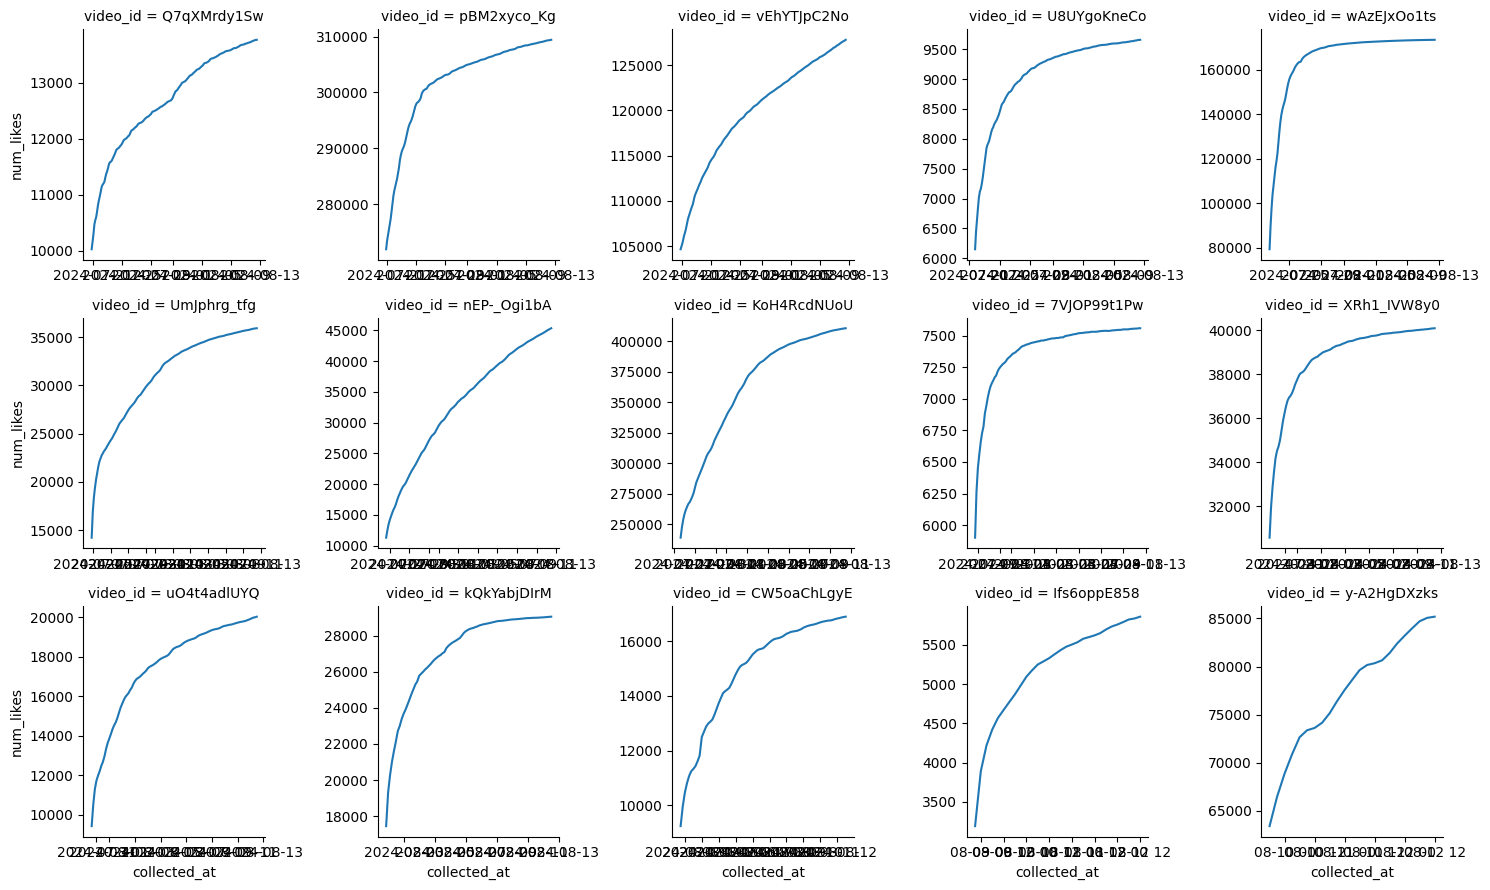

In [103]:
col = "num_likes"
id_data = video_fact.loc[video_fact["video_id"].isin(ids), ["video_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="video_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

## channel_fact

In [104]:
channel_fact.shape

(81847, 5)

In [105]:
channel_fact.dtypes

collected_at           datetime64[ns]
channel_id                     object
channel_total_views             int64
num_subscribers                 int64
num_videos                      int64
dtype: object

In [106]:
channel_fact.describe()

,collected_at,channel_total_views,num_subscribers,num_videos
count,81847,8.184700e+04,8.184700e+04,81847.000000
mean,2024-08-03 06:24:41.367264768,2.346488e+09,5.848355e+06,6236.691889
min,2024-07-20 21:00:07.479465,0.000000e+00,4.000000e+00,1.000000
25%,2024-07-29 12:00:08.277722112,1.684855e+08,6.510000e+05,207.000000
50%,2024-08-04 00:00:08.652744960,6.259867e+08,1.920000e+06,667.000000
75%,2024-08-08 15:00:08.939220992,1.794127e+09,5.420000e+06,2528.000000
max,2024-08-12 12:00:09.807998,8.696856e+10,3.090000e+08,295131.000000
std,NaN,5.788096e+09,1.710066e+07,22076.917681


Some channels have total views hidden. At least one channel has 1 video?!

In [107]:
channel_fact[["collected_at", "channel_id"]].nunique()

collected_at    182
channel_id      683
dtype: int64

In [108]:
channel_fact.isna().sum()

collected_at           0
channel_id             0
channel_total_views    0
num_subscribers        0
num_videos             0
dtype: int64

### channel_id

In [109]:
id_counts = channel_fact["channel_id"].value_counts()
id_counts

channel_id
UC2OREBiIbDChxvmDeg30Bsg    182
UC5sGdW8Jf7ijogDhcIFRmlw    182
UC7ABaoK3AFxuy_i4f6xV1tA    182
UCY6Ij8zOds0WJEeqCLOnqOQ    182
UCJbYdyufHR-cxOuY96KIoqA    182
                           ... 
UCWZmCMB7mmKWcXJSIPRhzZw      3
UCwVg9btOceLQuNCdoQk9CXg      2
UCTl3QQTvqHFjurroKxexy2Q      1
UCWizIdwZdmr43zfxlCktmNw      1
UC50xPFPma-nCS5GZpAFukpQ      1
Name: count, Length: 683, dtype: int64

Text(0, 0.5, 'Number of Time Points Collected')

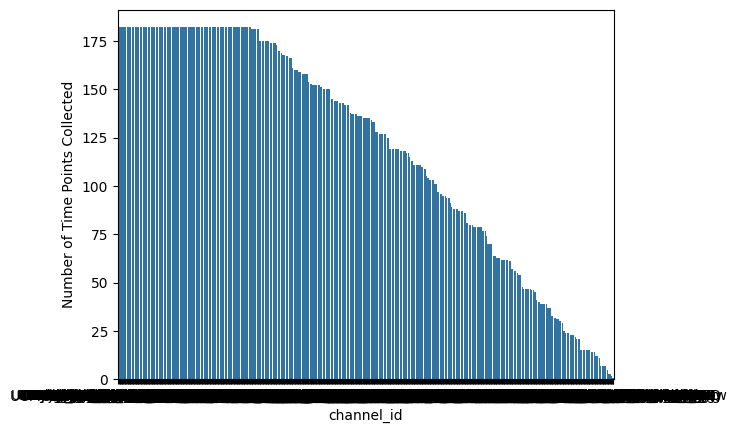

In [110]:
ax = sns.barplot(x=id_counts.index, y=id_counts)
ax.set_ylabel("Number of Time Points Collected")

In [111]:
id_counts2 = id_counts.value_counts()
id_counts2.sort_index(inplace=True, ascending=False)
id_counts2

count
182    183
181     11
175     16
174      8
173      1
      ... 
7       10
5        1
3        4
2        1
1        3
Name: count, Length: 100, dtype: int64

Text(0, 0.5, 'Number of Videos')

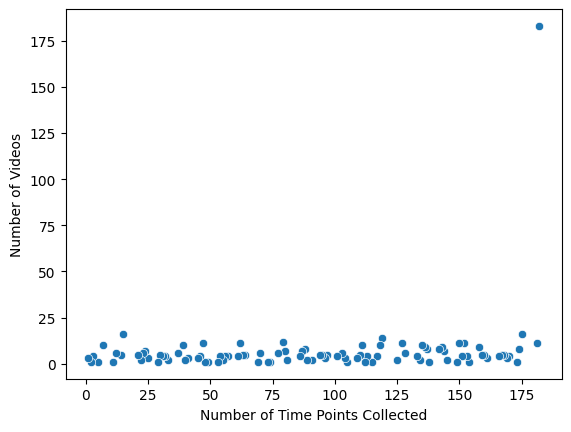

In [112]:
ax = sns.scatterplot(x=id_counts2.index, y=id_counts2)
ax.set_xlabel("Number of Time Points Collected")
ax.set_ylabel("Number of Videos")

In [113]:
ids = id_counts.sample(15).index
print(ids)

Index(['UCt_DaLB_NDqPVxezyvcfRtg', 'UC6-BgjsBa5R3PZQ_kZ8hKPg',
       'UCG8rbF3g2AMX70yOd8vqIZg', 'UCG3aWfAUJEdrGvGYwcfeefw',
       'UCbD8EppRX3ZwJSou-TVo90A', 'UCIZP6nCTyU9VV0zIhY7q1Aw',
       'UCYAJjqIukwm4r3GHEpJDhVw', 'UCIsbLox_y9dCIMLd8tdC6qg',
       'UCi4fcBVyo4CAnmdgXeO-NvA', 'UCedvOgsKFzcK3hA5taf3KoQ',
       'UCc9CjaAjsMMvaSghZB7-Kog', 'UCwdVyruxCCqMR4DtPLhtwlg',
       'UCV6FZ1FeUvBuzOb_AtbIJow', 'UC5k3Kc0avyDJ2nG9Kxm9JmQ',
       'UCMSqyGyyqI_zWkyS22pk7bA'],
      dtype='object', name='channel_id')


### channel_total_views

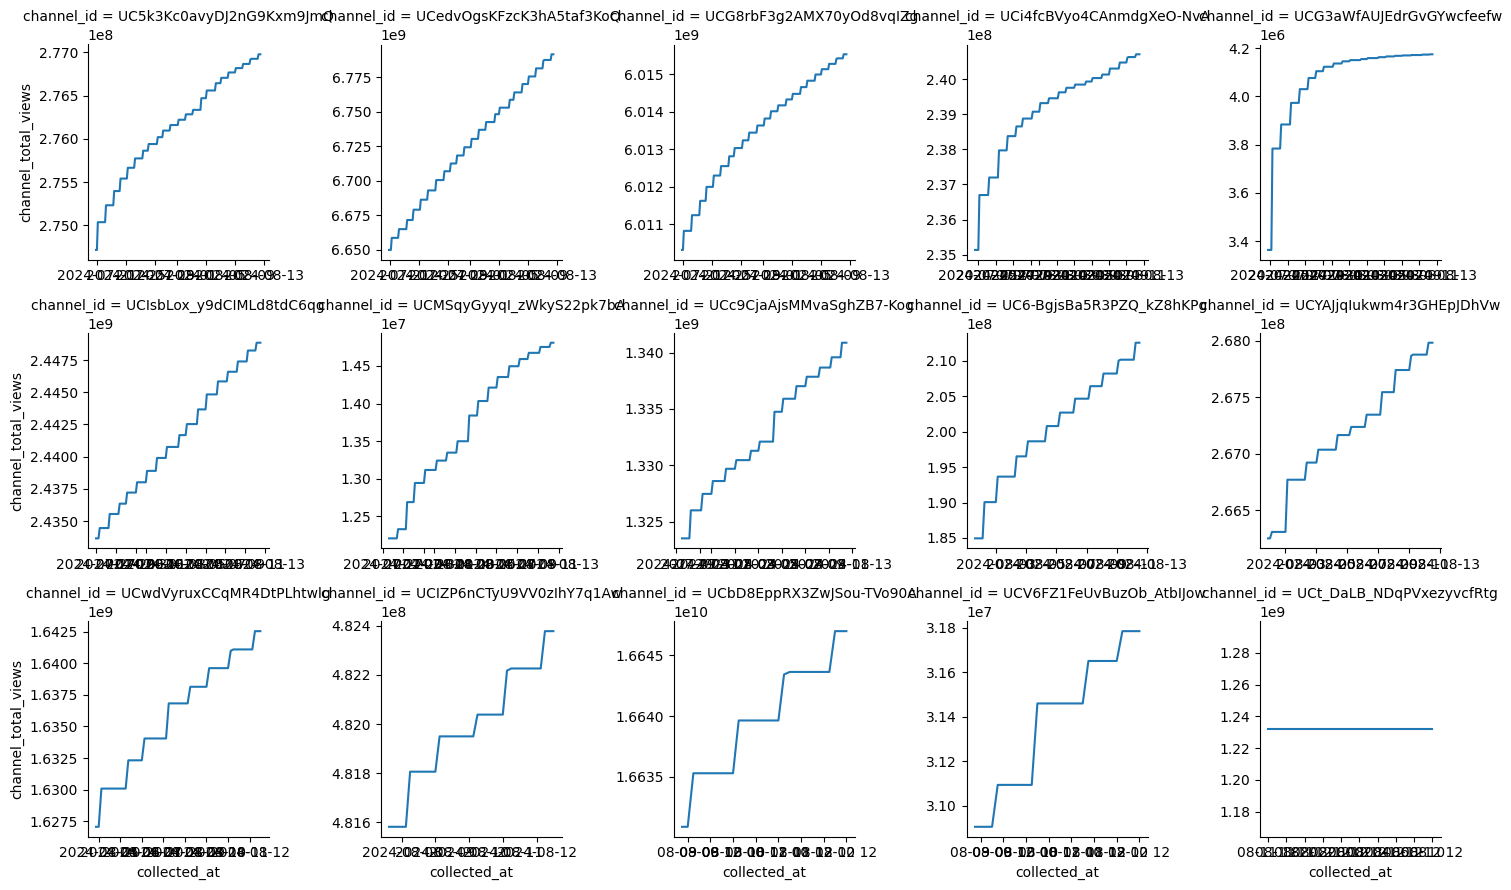

In [114]:
col = "channel_total_views"
id_data = channel_fact.loc[channel_fact["channel_id"].isin(ids), ["channel_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="channel_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_subscribers

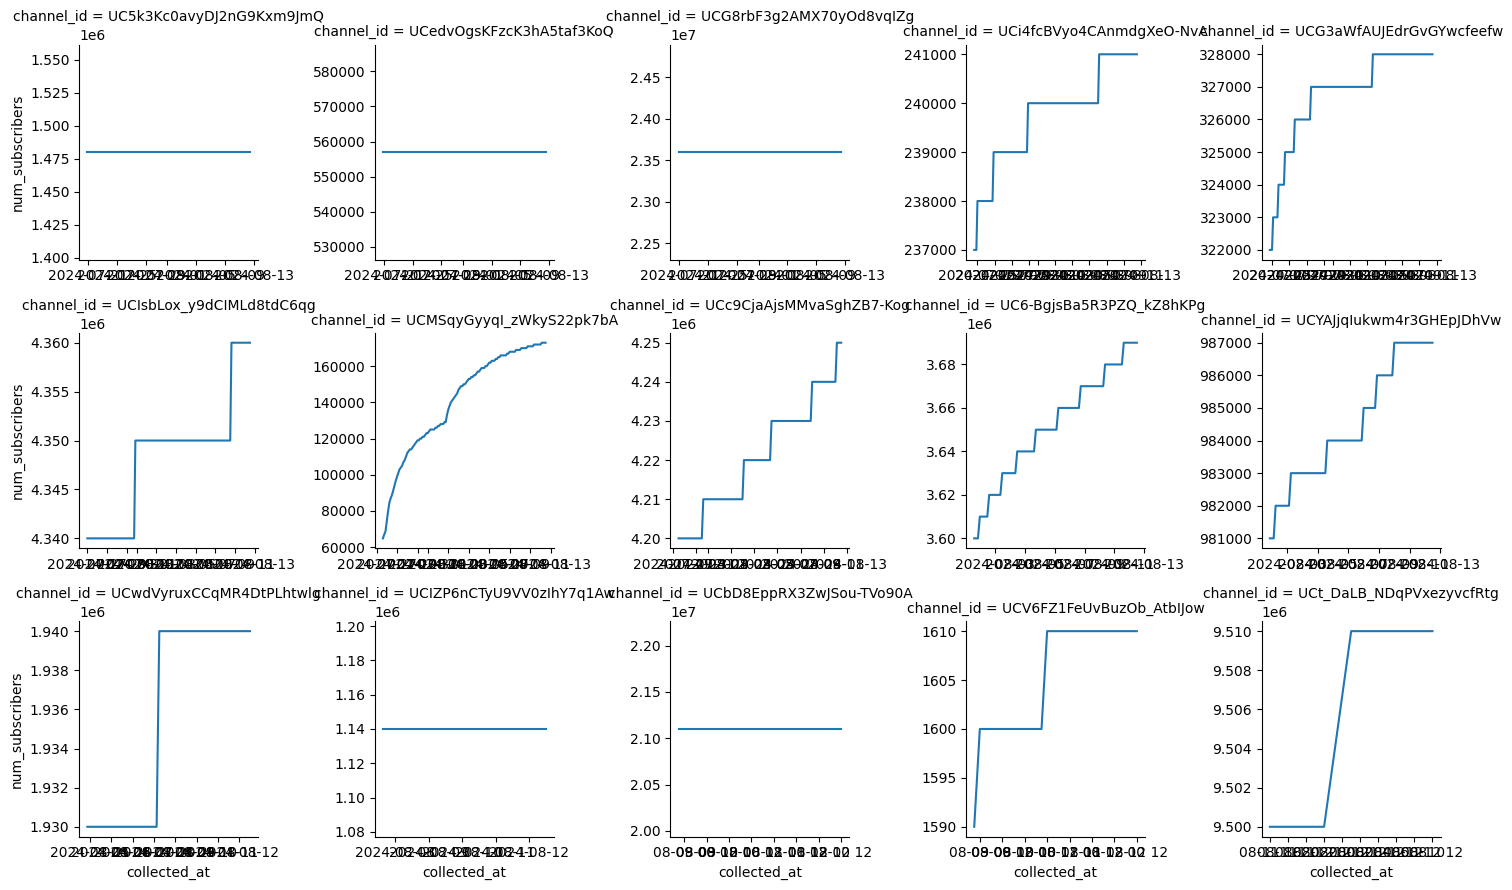

In [115]:
col = "num_subscribers"
id_data = channel_fact.loc[channel_fact["channel_id"].isin(ids), ["channel_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="channel_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_videos

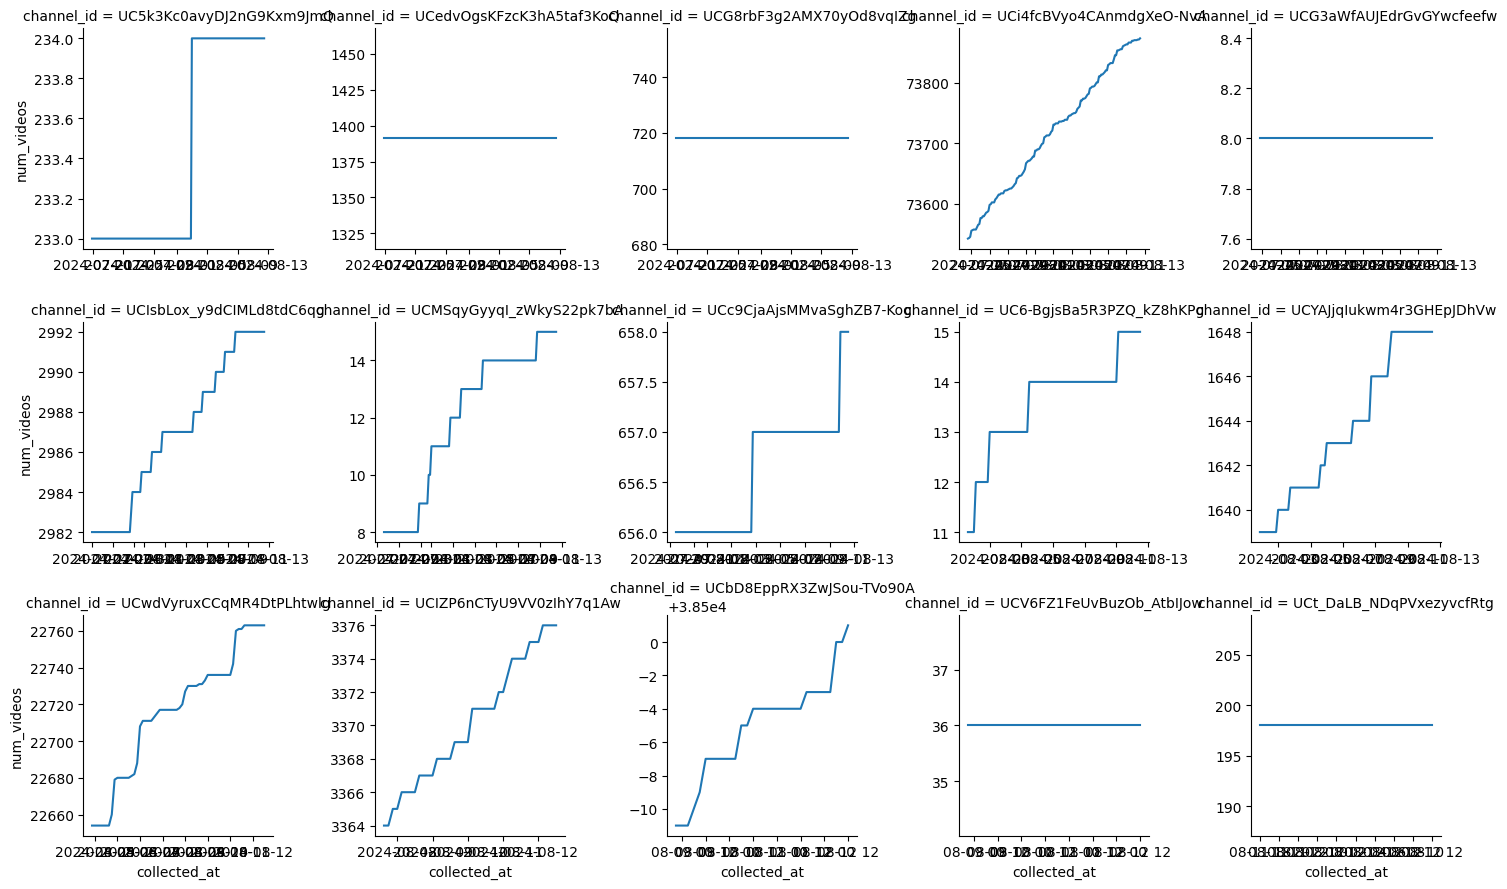

In [116]:
col = "num_videos"
id_data = channel_fact.loc[channel_fact["channel_id"].isin(ids), ["channel_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="channel_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

## video_dim

In [117]:
video_dim.shape

(948, 10)

In [118]:
video_dim.dtypes

video_id                     object
channel_id                   object
video_title                  object
video_description            object
num_tags                      int64
duration_seconds              int64
licensed_content               bool
made_for_kids                  bool
published_at         datetime64[ns]
category_id                   int64
dtype: object

In [119]:
video_dim.describe()

,num_tags,duration_seconds,published_at,category_id
count,948.000000,948.00000,948,948.000000
mean,15.871308,963.10865,2024-07-28 13:25:28.914556928,18.362869
min,0.000000,22.00000,2024-06-26 12:22:40,1.000000
25%,4.000000,199.75000,2024-07-21 06:16:22.750000128,17.000000
50%,15.000000,595.50000,2024-07-28 12:27:21.500000,20.000000
75%,25.000000,1370.75000,2024-08-05 08:00:19.249999872,24.000000
max,64.000000,26709.00000,2024-08-12 00:23:02,28.000000
std,12.843888,1309.96478,NaN,6.570162


### video_id

In [120]:
video_dim["video_id"].sample(15)

549    MnvOwjZPOCM
364    0--PNIolm5I
380    uFCXbpDoaus
789    JDiD8Z3lWQk
761    xPS0bI_Q4BU
538    HYO-YhT9lZE
863    onsfPUZIP74
423    _9prH7NFmLI
628    HcNILY4gtNI
162    _05Arr8b_2E
667    WGipYgcn8Xg
617    CW5oaChLgyE
202    EVIJUH29pjU
447    0pcmj6SFU38
131    j7YgKocz2W4
Name: video_id, dtype: object

In [121]:
video_dim["video_id"].apply(lambda x: len(x)).value_counts()

video_id
11    948
Name: count, dtype: int64

### video_title

In [122]:
video_dim["video_title"].sample(15)

389            200 Miles Off-roading With Oliver Anthony
890          "Truth or Flare" | Inanimate Insanity S2E15
629     I Collected EVERY NEW WOLF in Minecraft Hardcore
662                   World's Most Impossible Trickshots
298                  XG - UNDEFEATED (Performance Video)
579       Brawl Stars Animation: PAINT BRAWL STARTS NOW!
49     USA vs SERBIA | USAB SHOWCASE | FULL GAME HIGH...
87     Miniminter Reacts To 50 YouTubers Fight For $1...
207    Stray Kids (스트레이 키즈) - Chk Chk Boom | Show! Mu...
572            BoyWithUke - Ghost (Official Music Video)
752    Dead by Daylight | Castlevania | Official Trailer
619    I PROPOSED TO THE LOVE OF MY LIFE IN THE BAHAMAS!
490    can we build a fully RED townhouse in the sims...
103      PARTYNEXTDOOR - No Chill (Official Music Video)
908                 *NEW* FORTNITE SEASON 4 LIVE EVENT!!
Name: video_title, dtype: object

In [123]:
video_dim["video_title"].apply(lambda x: len(x)).value_counts()

video_title
49    31
43    25
42    24
47    23
40    21
      ..
11     2
4      1
86     1
88     1
18     1
Name: count, Length: 94, dtype: int64

### video_description

In [124]:
video_dim["video_description"].sample(15)

902    24 Hours was harder than expected, but I don't...
76     https://www.twitch.tv/kot4q\n\nKenny Beecham P...
134    SOCIAL MEDIA:\n@supremedreams_1\n@23_is_leland...
893    LeBron James and Kevin Durant stepped up in bi...
433    Beneath the surface of Azeroth the drums of wa...
302    A hydrothermal explosion happened at a geyser ...
699    Thanks to Shawn Cleanclick - follow here:\nhtt...
705    Oh! You found the hidden link! https://youtu.b...
55     The All Blacks and Fiji showcase their attacki...
784    FNAF x Fortnite Is CANCELLED..\nItem Shop Code...
715    USA TOUR TICKETS HERE\n► https://shop.kurtisco...
923    Are all these fancy new menu items better or w...
359    Thanks Send A Friend for Sponsoring this video...
172    NEW MERCH! - https://www.unspeakable.com/\n\nF...
176                                      The White House
Name: video_description, dtype: object

In [125]:
video_dim["video_description"].apply(lambda x: len(x)).value_counts()

video_description
562     5
0       5
304     4
555     4
598     4
       ..
2477    1
1182    1
543     1
1863    1
427     1
Name: count, Length: 756, dtype: int64

### num_tags

<Axes: xlabel='num_tags', ylabel='Count'>

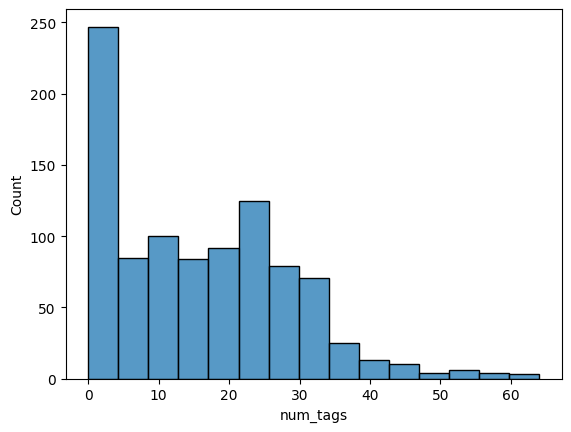

In [126]:
sns.histplot(video_dim, x="num_tags")

### duration_seconds

<Axes: xlabel='duration_seconds', ylabel='Count'>

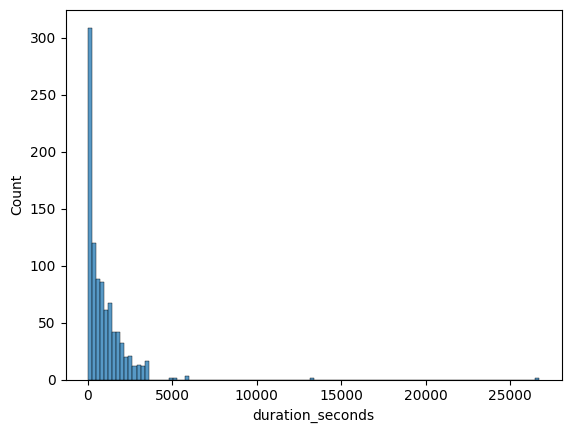

In [127]:
sns.histplot(video_dim, x="duration_seconds")

### licensed_content

In [128]:
video_dim["licensed_content"].value_counts()

licensed_content
True     870
False     78
Name: count, dtype: int64

### made_for_kids

In [129]:
video_dim["made_for_kids"].value_counts()

made_for_kids
False    943
True       5
Name: count, dtype: int64

### published_at

<Axes: xlabel='published_at', ylabel='Count'>

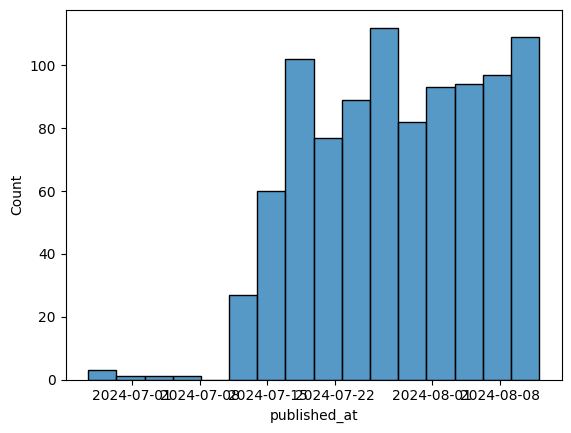

In [130]:
sns.histplot(video_dim, x="published_at")

### category_id

In [131]:
video_dim["category_id"].value_counts()

category_id
20    196
17    192
24    170
10    120
22     80
25     44
1      39
2      27
23     24
28     19
26     16
27     13
19      5
15      3
Name: count, dtype: int64

## channel_dim

In [132]:
channel_dim.shape

(683, 3)

In [133]:
channel_dim.dtypes

channel_id                  object
channel_name                object
created_datetime    datetime64[ns]
dtype: object

In [134]:
channel_dim.describe()

,created_datetime
count,683
mean,2014-07-03 20:35:45.558746880
min,2005-06-16 12:09:27
25%,2010-05-19 05:22:47
50%,2014-08-08 23:24:17
75%,2018-10-10 12:24:02.500000
max,2024-07-19 21:40:21.622480


### channel_id

In [135]:
channel_dim["channel_id"].sample(15)

455    UCJFFWX6gUh1fdcGFGSvthQg
314    UCdmcAwbdiXQWs9d4Qd4KzDw
5      UCuPivVjnfNo4mb3Oog_frZg
57     UC9RM-iSvTu1uPJb8X5yp3EQ
602    UC5UYMeKfZbFYnLHzoTJB1xA
462    UC6-BgjsBa5R3PZQ_kZ8hKPg
55     UCgWfS_47YPVbKx5EK4FLm4A
497    UCBAGtBjmMhfVUrv1Lc3Mdqw
370    UCLuQqm5mjCFoWNyBhL4G8Iw
122    UCJHA_jMfCvEnv-3kRjTCQXw
255    UCPpddbTbOr_uWWQT9Pw1rbA
458    UCqVCSWnuOSPm26orvNDTuWQ
150    UChBEbMKI1eCcejTtmI32UEw
21     UCo_IB5145EVNcf8hw1Kku7w
97     UCRijo3ddMTht_IHyNSNXpNQ
Name: channel_id, dtype: object

In [136]:
channel_dim["channel_id"].apply(lambda x: len(x)).value_counts()

channel_id
24    683
Name: count, dtype: int64

### channel_name

In [137]:
channel_dim["channel_name"].sample(15)

678         Eamon & Bec
82             Alpharad
281             Settled
20             JADEVEVO
627         YeriMuaVEVO
449           La Cracka
410     Imbrandonfarris
662       Brick Science
625        Hoop Reports
51     GracieAbramsVEVO
144     Stranger Things
159            Fireship
239       Gordon Ramsay
384       Gabriel Varga
523        The Backlogs
Name: channel_name, dtype: object

In [138]:
channel_dim["channel_name"].apply(lambda x: len(x)).value_counts()

channel_name
10    58
11    58
12    55
13    54
14    50
15    41
7     41
8     36
9     35
17    32
5     30
16    30
6     24
19    23
18    18
3     18
20    15
4     14
24     7
26     7
21     6
22     6
23     5
31     3
25     3
27     3
34     2
2      2
28     2
38     1
50     1
37     1
36     1
29     1
Name: count, dtype: int64

### created_datetime

<Axes: xlabel='created_datetime', ylabel='Count'>

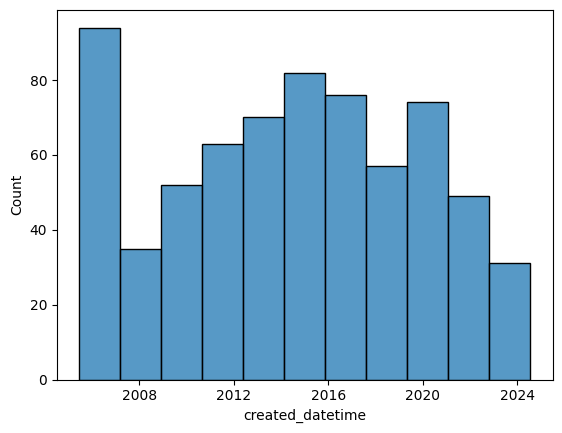

In [139]:
sns.histplot(channel_dim, x="created_datetime")

## categories_dim

In [140]:
print(categories_dim)

    category_id          category_name
0             1       Film & Animation
1             2       Autos & Vehicles
2            10                  Music
3            15         Pets & Animals
4            17                 Sports
5            18           Short Movies
6            19        Travel & Events
7            20                 Gaming
8            21          Videoblogging
9            22         People & Blogs
10           23                 Comedy
11           24          Entertainment
12           25        News & Politics
13           26          Howto & Style
14           27              Education
15           28   Science & Technology
16           29  Nonprofits & Activism
17           30                 Movies
18           31        Anime/Animation
19           32       Action/Adventure
20           33               Classics
21           34                 Comedy
22           35            Documentary
23           36                  Drama
24           37          

# Data Preparation
## Combine video_fact, video_dim, and categories_dim

In [226]:
video_all = (video_fact.merge(video_dim, on="video_id", how="inner")
             .merge(categories_dim, on="category_id", how="inner"))

In [227]:
video_all.rename(columns={"collected_at":"video_collected_dt", "published_at":"video_published_dt"}, inplace=True)

In [228]:
video_all.shape, video_all.columns

((102763, 15),
 Index(['video_collected_dt', 'video_id', 'num_views', 'num_likes',
        'num_comments', 'channel_id', 'video_title', 'video_description',
        'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
        'video_published_dt', 'category_id', 'category_name'],
       dtype='object'))

## Combine channel_fact and channel_dim

In [229]:
channel_all = channel_fact.merge(channel_dim, on="channel_id", how="inner")

In [230]:
channel_all.rename(columns={"collected_at":"channel_collected_dt", "created_datetime":"channel_created_dt"}, inplace=True)

In [231]:
channel_all.shape, channel_all.columns

((81847, 7),
 Index(['channel_collected_dt', 'channel_id', 'channel_total_views',
        'num_subscribers', 'num_videos', 'channel_name', 'channel_created_dt'],
       dtype='object'))

## Join video and channel data

In [232]:
channel_all["collected_date"] = channel_all["channel_collected_dt"].dt.date
channel_all["collected_hour"] = channel_all["channel_collected_dt"].dt.hour
channel_all[["collected_date", "collected_hour"]].head()

,collected_date,collected_hour
0,2024-07-20,21
1,2024-07-21,0
2,2024-07-21,3
3,2024-07-21,6
4,2024-07-21,9


In [233]:
video_all["collected_date"] = video_all["video_collected_dt"].dt.date
video_all["collected_hour"] = video_all["video_collected_dt"].dt.hour
video_all[["collected_date", "collected_hour"]].head()

,collected_date,collected_hour
0,2024-07-20,21
1,2024-07-21,0
2,2024-07-21,3
3,2024-07-21,6
4,2024-07-21,9


In [234]:
merged = video_all.merge(channel_all, on=["channel_id", "collected_date", "collected_hour"], how="left", suffixes=["_video", "_channel"])

In [235]:
merged.isna().sum()

video_collected_dt      0
video_id                0
num_views               0
num_likes               0
num_comments            0
channel_id              0
video_title             0
video_description       0
num_tags                0
duration_seconds        0
licensed_content        0
made_for_kids           0
video_published_dt      0
category_id             0
category_name           0
collected_date          0
collected_hour          0
channel_collected_dt    0
channel_total_views     0
num_subscribers         0
num_videos              0
channel_name            0
channel_created_dt      0
dtype: int64

In [236]:
merged.head()

,video_collected_dt,video_id,num_views,num_likes,num_comments,channel_id,video_title,video_description,num_tags,duration_seconds,...,category_id,category_name,collected_date,collected_hour,channel_collected_dt,channel_total_views,num_subscribers,num_videos,channel_name,channel_created_dt
0,2024-07-20 21:00:06.211863,laNA2HgwYXU,7023341,334132,16936,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,24,Entertainment,2024-07-20,21,2024-07-20 21:00:07.479465,828829584,4560000,319,Ryan Reynolds,2015-11-03 22:28:21
1,2024-07-21 00:00:05.864281,laNA2HgwYXU,7293604,339515,17160,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,24,Entertainment,2024-07-21,0,2024-07-21 00:00:07.262266,828829584,4560000,319,Ryan Reynolds,2015-11-03 22:28:21
2,2024-07-21 03:00:05.532334,laNA2HgwYXU,7541497,344200,17332,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,24,Entertainment,2024-07-21,3,2024-07-21 03:00:06.908555,828829584,4560000,319,Ryan Reynolds,2015-11-03 22:28:21
3,2024-07-21 06:00:06.161407,laNA2HgwYXU,7757614,348594,17430,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,24,Entertainment,2024-07-21,6,2024-07-21 06:00:07.605247,832556785,4560000,319,Ryan Reynolds,2015-11-03 22:28:21
4,2024-07-21 09:00:05.730932,laNA2HgwYXU,7965163,352343,17554,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,24,Entertainment,2024-07-21,9,2024-07-21 09:00:07.113590,832556785,4560000,319,Ryan Reynolds,2015-11-03 22:28:21


## Some datetime feature engineering

In [237]:
merged["channel_days_since_created"] = (merged["channel_created_dt"] - merged["channel_collected_dt"])/pd.Timedelta("-1d")
merged["hours_since_published"] = (merged["video_published_dt"] - merged["video_collected_dt"])/pd.Timedelta("-1d")

In [238]:
merged[["hours_since_published", "channel_days_since_created"]]

,hours_since_published,channel_days_since_created
0,1.294111,3181.938732
1,1.419107,3182.063730
2,1.544103,3182.188726
3,1.669111,3182.313734
4,1.794106,3182.438728
...,...,...
102758,1.400346,1856.281071
102759,1.525344,1856.406069
102760,1.650341,1856.531067
102761,1.775348,1856.656075


## Only get stats for the first time point, time point one day after, and time point one week after

In [248]:
merged.columns

Index(['video_collected_dt', 'video_id', 'num_views', 'num_likes',
       'num_comments', 'channel_id', 'video_title', 'video_description',
       'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
       'video_published_dt', 'category_id', 'category_name', 'collected_date',
       'collected_hour', 'channel_collected_dt', 'channel_total_views',
       'num_subscribers', 'num_videos', 'channel_name', 'channel_created_dt',
       'channel_days_since_created', 'hours_since_published'],
      dtype='object')

In [245]:
# first time point
first = merged.groupby("video_id").nth(0)
print(first.shape)
first.head()

(948, 25)


,video_collected_dt,video_id,num_views,num_likes,num_comments,channel_id,video_title,video_description,num_tags,duration_seconds,...,collected_date,collected_hour,channel_collected_dt,channel_total_views,num_subscribers,num_videos,channel_name,channel_created_dt,channel_days_since_created,hours_since_published
0,2024-07-20 21:00:06.211863,laNA2HgwYXU,7023341,334132,16936,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,2024-07-20,21,2024-07-20 21:00:07.479465,828829584,4560000,319,Ryan Reynolds,2015-11-03 22:28:21,3181.938732,1.294111
182,2024-07-20 21:00:06.211863,u_as_PygtDc,1022746,46145,4234,UCGTKwjs1ctvgwCRa67RNO-Q,Uh Oh…My Boaterhome Might Actually Be a BUMMER...,Thanks to ARMRA Colostrum for sponsoring this ...,44,1657,...,2024-07-20,21,2024-07-20 21:00:07.479465,876439042,3890000,776,HeavyDSparks,2015-05-01 22:33:04,3367.935457,0.938880
364,2024-07-20 21:00:06.211863,Qn1UJssT-mU,13106958,716571,57805,UCsSsgPaZ2GSmO6il8Cb5iGA,skibidi toilet 76 (part 2),cameramen attempt to escape city\n\nfull-scree...,7,268,...,2024-07-20,21,2024-07-20 21:00:07.479465,17058047576,42900000,299,DaFuq!?Boom!,2016-06-06 15:19:28,2966.236568,1.666484
546,2024-07-20 21:00:06.211863,H-c1bAk9Soc,535473,25595,1943,UCOgGAfSUy5LvEyVS_LF5kdw,Brits try Texas Ballpark food!,"Get 4 months extra on a 2 year plan, plus up t...",63,876,...,2024-07-20,21,2024-07-20 21:00:07.479465,1164270894,3980000,836,JOLLY,2015-10-07 18:25:54,3209.107100,1.228880
728,2024-07-20 21:00:06.211863,7Nk5C6o3PkQ,2272245,104098,4229,UCPD_bxCRGpmmeQcbe2kpPaA,Childish Gambino Goes On a Vision Quest While ...,"Donald Glover—a.k.a., Childish Gambino—is a fi...",25,1393,...,2024-07-20,21,2024-07-20 21:00:07.479465,3840733051,13600000,1691,First We Feast,2014-02-28 21:48:23,3794.966487,2.249945


In [246]:
# one day after first time point
oneday = merged.groupby("video_id").nth(8)
print(oneday.shape)
oneday.head()

(900, 25)


,video_collected_dt,video_id,num_views,num_likes,num_comments,channel_id,video_title,video_description,num_tags,duration_seconds,...,collected_date,collected_hour,channel_collected_dt,channel_total_views,num_subscribers,num_videos,channel_name,channel_created_dt,channel_days_since_created,hours_since_published
8,2024-07-21 21:00:05.719201,laNA2HgwYXU,8615067,363859,17933,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,2024-07-21,21,2024-07-21 21:00:07.179999,832556785,4560000,319,Ryan Reynolds,2015-11-03 22:28:21,3182.938729,2.294106
190,2024-07-21 21:00:05.719201,u_as_PygtDc,1387795,54569,5031,UCGTKwjs1ctvgwCRa67RNO-Q,Uh Oh…My Boaterhome Might Actually Be a BUMMER...,Thanks to ARMRA Colostrum for sponsoring this ...,44,1657,...,2024-07-21,21,2024-07-21 21:00:07.179999,878115008,3890000,777,HeavyDSparks,2015-05-01 22:33:04,3368.935453,1.938874
372,2024-07-21 21:00:05.719201,Qn1UJssT-mU,14409552,738857,58807,UCsSsgPaZ2GSmO6il8Cb5iGA,skibidi toilet 76 (part 2),cameramen attempt to escape city\n\nfull-scree...,7,268,...,2024-07-21,21,2024-07-21 21:00:07.179999,17074530703,42900000,299,DaFuq!?Boom!,2016-06-06 15:19:28,2967.236565,2.666478
554,2024-07-21 21:00:05.719201,H-c1bAk9Soc,671950,29551,2178,UCOgGAfSUy5LvEyVS_LF5kdw,Brits try Texas Ballpark food!,"Get 4 months extra on a 2 year plan, plus up t...",63,876,...,2024-07-21,21,2024-07-21 21:00:07.179999,1166104164,3980000,836,JOLLY,2015-10-07 18:25:54,3210.107097,2.228874
736,2024-07-21 21:00:05.719201,7Nk5C6o3PkQ,2621584,115550,4601,UCPD_bxCRGpmmeQcbe2kpPaA,Childish Gambino Goes On a Vision Quest While ...,"Donald Glover—a.k.a., Childish Gambino—is a fi...",25,1393,...,2024-07-21,21,2024-07-21 21:00:07.179999,3843978940,13600000,1692,First We Feast,2014-02-28 21:48:23,3795.966484,3.249939


In [247]:
# one week after the first time point
oneweek = merged.groupby("video_id").nth(56)
print(oneweek.shape)
oneweek.head()

(697, 25)


,video_collected_dt,video_id,num_views,num_likes,num_comments,channel_id,video_title,video_description,num_tags,duration_seconds,...,collected_date,collected_hour,channel_collected_dt,channel_total_views,num_subscribers,num_videos,channel_name,channel_created_dt,channel_days_since_created,hours_since_published
56,2024-07-27 21:00:05.811850,laNA2HgwYXU,10178441,404423,18802,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,2024-07-27,21,2024-07-27 21:00:07.899199,838841635,4580000,321,Ryan Reynolds,2015-11-03 22:28:21,3188.938737,8.294107
238,2024-07-27 21:00:05.811850,u_as_PygtDc,2019230,70374,6578,UCGTKwjs1ctvgwCRa67RNO-Q,Uh Oh…My Boaterhome Might Actually Be a BUMMER...,Thanks to ARMRA Colostrum for sponsoring this ...,44,1657,...,2024-07-27,21,2024-07-27 21:00:07.899199,883126105,3900000,783,HeavyDSparks,2015-05-01 22:33:04,3374.935462,7.938875
420,2024-07-27 21:00:05.811850,Qn1UJssT-mU,16876175,780063,60523,UCsSsgPaZ2GSmO6il8Cb5iGA,skibidi toilet 76 (part 2),cameramen attempt to escape city\n\nfull-scree...,7,268,...,2024-07-27,21,2024-07-27 21:00:07.899199,17135406506,43000000,299,DaFuq!?Boom!,2016-06-06 15:19:28,2973.236573,8.666479
602,2024-07-27 21:00:05.811850,H-c1bAk9Soc,904825,36447,2624,UCOgGAfSUy5LvEyVS_LF5kdw,Brits try Texas Ballpark food!,"Get 4 months extra on a 2 year plan, plus up t...",63,876,...,2024-07-27,21,2024-07-27 21:00:07.899199,1173325007,3990000,840,JOLLY,2015-10-07 18:25:54,3216.107105,8.228875
784,2024-07-27 21:00:05.811850,7Nk5C6o3PkQ,3473190,144126,5234,UCPD_bxCRGpmmeQcbe2kpPaA,Childish Gambino Goes On a Vision Quest While ...,"Donald Glover—a.k.a., Childish Gambino—is a fi...",25,1393,...,2024-07-27,21,2024-07-27 21:00:07.899199,3871349190,13700000,1702,First We Feast,2014-02-28 21:48:23,3801.966492,9.249940


# Questions

## How well does a video need to do to show up on "most popular"?

In [249]:
first.columns

Index(['video_collected_dt', 'video_id', 'num_views', 'num_likes',
       'num_comments', 'channel_id', 'video_title', 'video_description',
       'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
       'video_published_dt', 'category_id', 'category_name', 'collected_date',
       'collected_hour', 'channel_collected_dt', 'channel_total_views',
       'num_subscribers', 'num_videos', 'channel_name', 'channel_created_dt',
       'channel_days_since_created', 'hours_since_published'],
      dtype='object')

In [250]:
cols = ["num_views", "num_likes", "num_comments", "num_tags", "duration_seconds", "hours_since_published"]
first[cols].describe().apply(lambda x: x.apply('{0:.5f}'.format)) # gets rid of scientific notation

,num_views,num_likes,num_comments,num_tags,duration_seconds,hours_since_published
count,948.00000,948.00000,948.00000,948.00000,948.00000,948.00000
mean,1326200.83544,65021.01688,4677.61709,15.87131,963.10865,1.48343
std,6791163.04029,361636.02704,19306.43610,12.84389,1309.96478,2.27201
min,30340.00000,0.00000,0.00000,0.00000,22.00000,0.08270
25%,231150.25000,8055.00000,738.75000,4.00000,199.75000,0.48435
50%,440626.50000,18641.50000,1579.00000,15.00000,595.50000,0.80140
75%,927748.25000,43307.50000,3415.25000,25.00000,1370.75000,1.12453
max,159559695.00000,7392365.00000,337068.00000,64.00000,26709.00000,24.35933


- The least viewed video had 30k views and the most viewed had 159 million before it was "most popular"
- Some "most popular" videos have no likes, no comments, and/or no tags.
- Videos can be as few as 22 seconds long or as many as 13000 seconds long (3.6 hrs)
- 75% of videos that show up on most popular have been out for less than 30 hours.

In [251]:
melted = first[cols].melt(var_name="column")
melted.sample(5)

,column,value
5684,hours_since_published,0.566932
2386,num_comments,942.000000
2971,num_tags,0.000000
3098,num_tags,7.000000
1543,num_likes,40602.000000


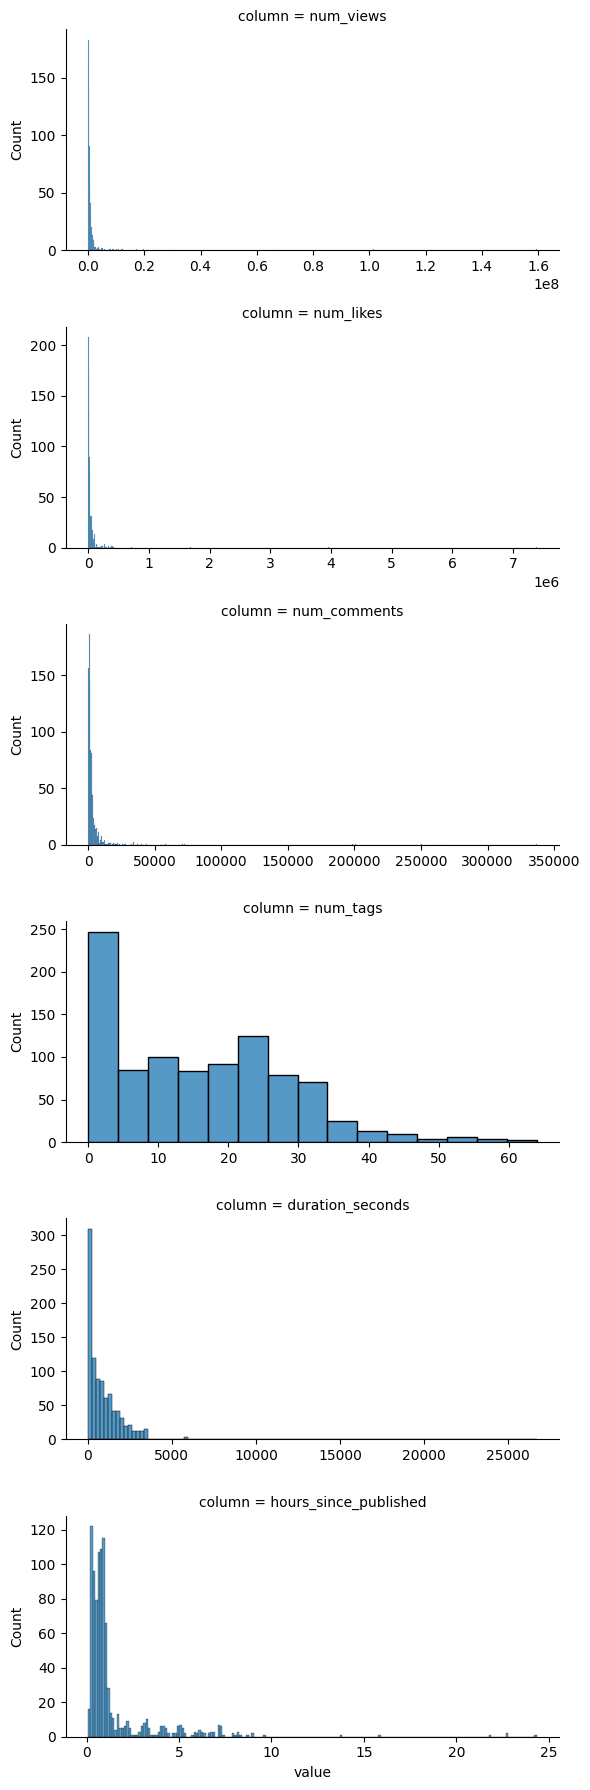

In [252]:
g = sns.FacetGrid(melted, row="column", sharey=False, sharex=False, aspect=2)
g.map_dataframe(sns.histplot, "value")

There are many outliers for views and comments and likes.

In [253]:
no_views = first.loc[first["num_views"] == 0]
no_views.shape[0]/first.shape[0] * 100

0.0

In [254]:
# how many videos have 0 likes, comments, or tags?
no_comments = first.loc[first["num_comments"] == 0]
no_comments.shape[0]/first.shape[0] * 100

2.2151898734177213

2% of videos have comments disabled

In [255]:
no_tags = first.loc[first["num_tags"] == 0]
no_tags.shape[0]/first.shape[0] * 100

16.455696202531644

17% of videos have no tags

In [256]:
no_likes = first.loc[first["num_likes"] == 0]
no_likes.shape[0]/first.shape[0] * 100

0.42194092827004215

.4% of videos have likes hidden

In [257]:
corr_cols = cols + ['made_for_kids', 'licensed_content']

<Axes: >

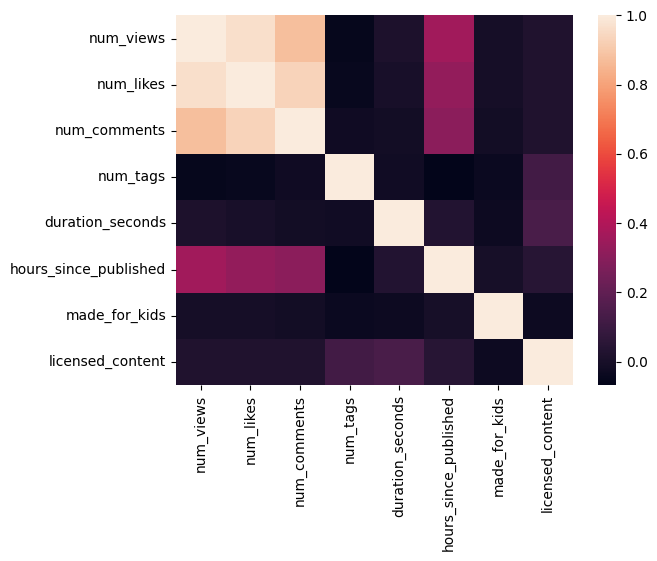

In [258]:
sns.heatmap(first[corr_cols].corr())

Views, likes, and comments are correlated, and there's a slight correlation between the video being out for longer and having more likes, views, and comments. Not surprising. The other variables seem to have no effect on views.

### Conclusion
There doesn't seem to be any specific level of performance for videos to show up on most popular. It's hard to even answer this question because I don't have any information on what the videos' stats looked like before they were on most popular.

## How much do views grow after one day and one week?
### One day growth

In [259]:
oneday.shape

(900, 25)

In [260]:
growth_1day = first[["video_id", "num_views"]].merge(oneday[["video_id", "num_views"]],
                                                         on="video_id", 
                                                         how="inner", 
                                                         suffixes=("_first", "_1day"))
growth_1day

,video_id,num_views_first,num_views_1day
0,laNA2HgwYXU,7023341,8615067
1,u_as_PygtDc,1022746,1387795
2,Qn1UJssT-mU,13106958,14409552
3,H-c1bAk9Soc,535473,671950
4,7Nk5C6o3PkQ,2272245,2621584
...,...,...,...
895,KQFMB-Mf1LA,296079,717963
896,1eafBVGTJQ8,114218,280084
897,ZvQr87R3BqU,475184,821795
898,QLI0XOFpK0A,1084317,2134099


In [261]:
growth_1day["abs_growth"] = growth_1day["num_views_1day"] - growth_1day["num_views_first"]
growth_1day["pct_growth"] = growth_1day["abs_growth"] / growth_1day["num_views_first"]
growth_1day

,video_id,num_views_first,num_views_1day,abs_growth,pct_growth
0,laNA2HgwYXU,7023341,8615067,1591726,0.226634
1,u_as_PygtDc,1022746,1387795,365049,0.356930
2,Qn1UJssT-mU,13106958,14409552,1302594,0.099382
3,H-c1bAk9Soc,535473,671950,136477,0.254872
4,7Nk5C6o3PkQ,2272245,2621584,349339,0.153742
...,...,...,...,...,...
895,KQFMB-Mf1LA,296079,717963,421884,1.424903
896,1eafBVGTJQ8,114218,280084,165866,1.452188
897,ZvQr87R3BqU,475184,821795,346611,0.729425
898,QLI0XOFpK0A,1084317,2134099,1049782,0.968150


In [262]:
growth_1day.describe().apply(lambda x: x.apply('{0:.5f}'.format)) # gets rid of scientific notation

,num_views_first,num_views_1day,abs_growth,pct_growth
count,900.00000,900.00000,900.00000,900.00000
mean,1357625.98667,1820488.72111,462862.73444,0.70497
std,6967625.41485,7616903.77730,1752276.09718,0.91563
min,30340.00000,45072.00000,138.00000,0.00009
25%,228851.25000,359645.50000,82800.00000,0.22298
50%,432569.50000,672526.50000,180728.00000,0.44629
75%,924469.00000,1357866.50000,407789.00000,0.89475
max,159559695.00000,164670475.00000,48086405.00000,12.69989


After becoming most popular, videos grow by 447 thousand +/- 1.8 million in one day

### One week growth

In [263]:
oneweek.shape

(697, 25)

In [264]:
growth_1week = first[["video_id", "num_views"]].merge(oneweek[["video_id", "num_views"]],
                                                         on="video_id", 
                                                         how="inner", 
                                                         suffixes=("_first", "_1day"))
growth_1week

,video_id,num_views_first,num_views_1day
0,laNA2HgwYXU,7023341,10178441
1,u_as_PygtDc,1022746,2019230
2,Qn1UJssT-mU,13106958,16876175
3,H-c1bAk9Soc,535473,904825
4,7Nk5C6o3PkQ,2272245,3473190
...,...,...,...
692,0luAzyPl7DI,207844,378371
693,uQ8yDdtoFj0,894317,1106033
694,KQFMB-Mf1LA,296079,1164978
695,1eafBVGTJQ8,114218,767587


In [265]:
growth_1week["abs_growth"] = growth_1week["num_views_1day"] - growth_1week["num_views_first"]
growth_1week["pct_growth"] = growth_1week["abs_growth"] / growth_1week["num_views_first"]
growth_1week

,video_id,num_views_first,num_views_1day,abs_growth,pct_growth
0,laNA2HgwYXU,7023341,10178441,3155100,0.449231
1,u_as_PygtDc,1022746,2019230,996484,0.974322
2,Qn1UJssT-mU,13106958,16876175,3769217,0.287574
3,H-c1bAk9Soc,535473,904825,369352,0.689768
4,7Nk5C6o3PkQ,2272245,3473190,1200945,0.528528
...,...,...,...,...,...
692,0luAzyPl7DI,207844,378371,170527,0.820457
693,uQ8yDdtoFj0,894317,1106033,211716,0.236735
694,KQFMB-Mf1LA,296079,1164978,868899,2.934686
695,1eafBVGTJQ8,114218,767587,653369,5.720368


In [266]:
growth_1week.describe().apply(lambda x: x.apply('{0:.5f}'.format)) # gets rid of scientific notation

,num_views_first,num_views_1day,abs_growth,pct_growth
count,697.00000,697.00000,697.00000,697.00000
mean,1534262.16643,2815414.51363,1281152.34720,1.93484
std,7862410.93347,10791048.98527,4654268.84326,3.10928
min,30340.00000,81168.00000,-30232.00000,-0.08771
25%,224725.00000,554693.00000,197166.00000,0.47410
50%,448434.00000,1077912.00000,474661.00000,1.09939
75%,991533.00000,2107629.00000,1122415.00000,2.16100
max,159559695.00000,197363048.00000,104052284.00000,33.99143


Most popular videos grow by 1.1 million +/- 2.7 million in one week.

## What types of videos perform the best?
Judging based off one week performance

<Axes: >

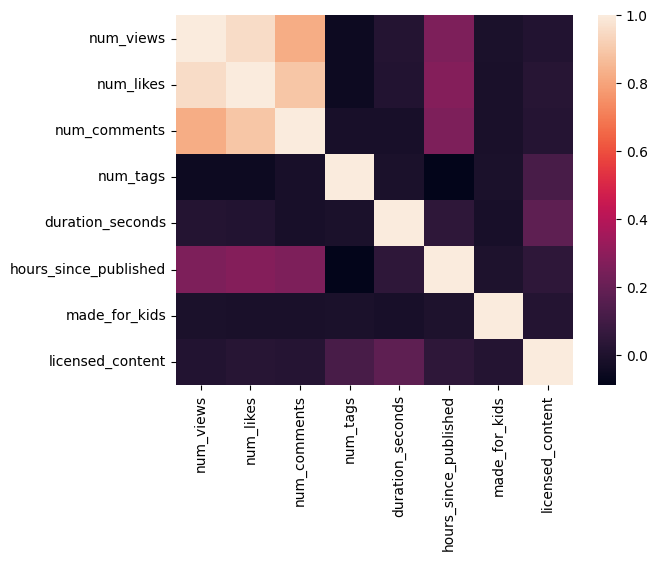

In [267]:
sns.heatmap(oneweek[corr_cols].corr())

In [268]:
best_categories = oneweek.groupby("category_name")["num_views"].median().sort_values(ascending=False)
best_categories = best_categories.reset_index()
best_categories.columns = ["category_name", "median_views"]
best_categories

,category_name,median_views
0,Science & Technology,2149504.0
1,Music,1875027.5
2,Pets & Animals,1864318.0
3,Education,1741615.0
4,Film & Animation,1684465.5
5,Comedy,1255655.0
6,Entertainment,1246339.0
7,News & Politics,1235976.0
8,Travel & Events,1106033.0
9,Sports,1000768.0


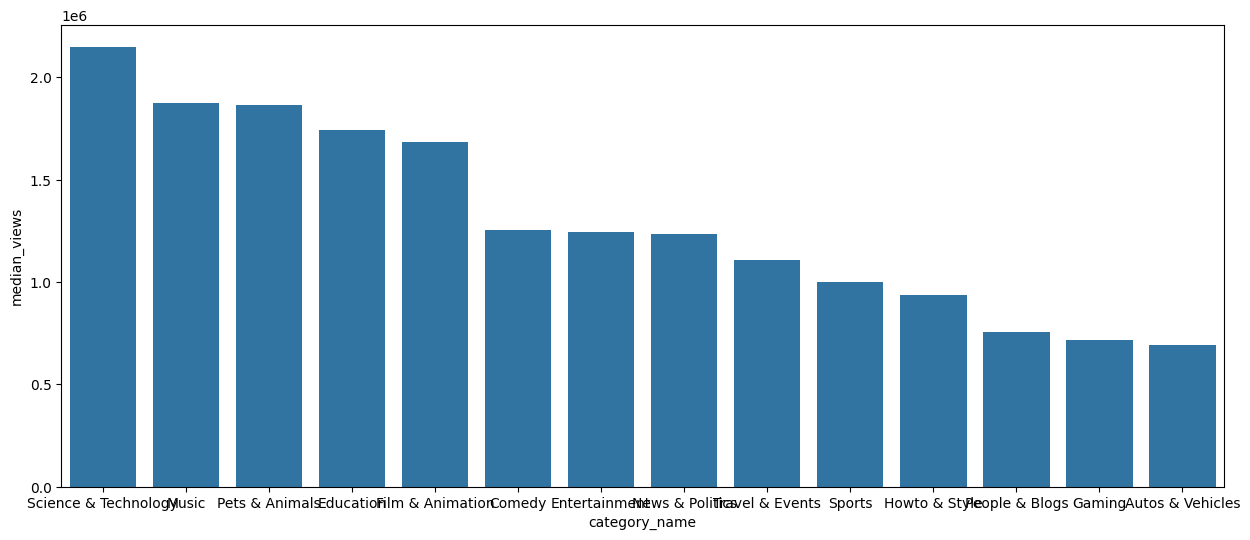

In [269]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(data=best_categories, x="category_name", y="median_views", ax=ax)

Music, Science & Technology, and Pets & Animals perform the best when removing outliers.

In [270]:
mean_best_cat = oneweek.groupby("category_name")["num_views"].agg(np.mean).sort_values(ascending=False)
mean_best_cat

category_name
Entertainment           5.694249e+06
Music                   4.400788e+06
Film & Animation        4.211570e+06
Science & Technology    2.937981e+06
News & Politics         2.109001e+06
Pets & Animals          1.864318e+06
Education               1.847674e+06
Sports                  1.797201e+06
Comedy                  1.794028e+06
Howto & Style           1.349142e+06
People & Blogs          1.316157e+06
Gaming                  1.152204e+06
Autos & Vehicles        1.104521e+06
Travel & Events         1.012866e+06
Name: num_views, dtype: float64

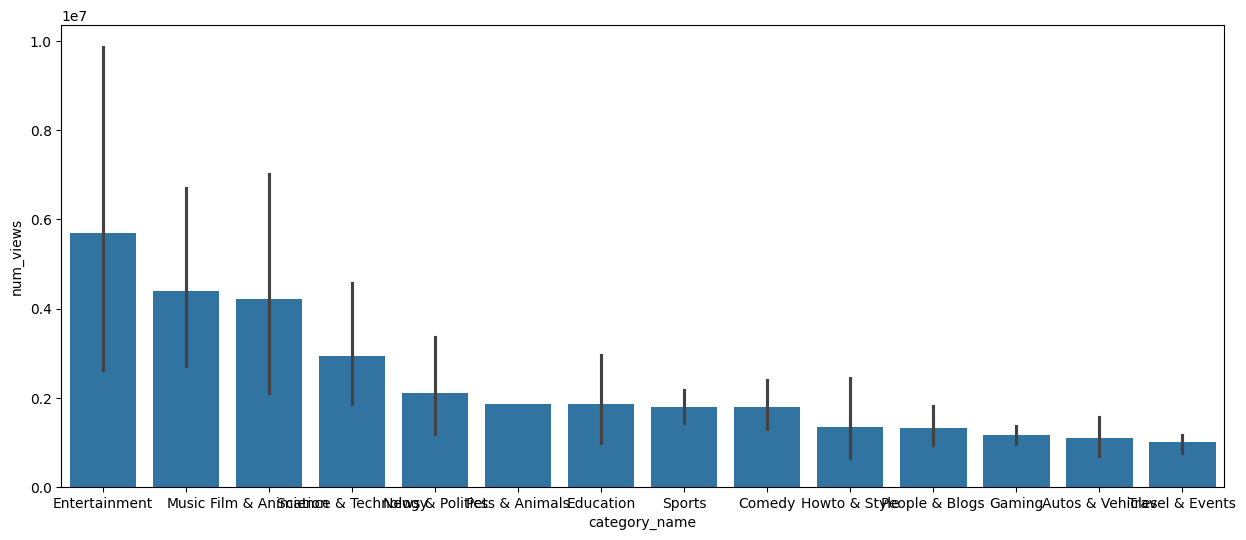

In [271]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(data=oneweek, x="category_name", y="num_views", order=mean_best_cat.index,
                 ax=ax)

Entertainment, Music, and Film & Animation dominate when looking at average views. They also have the largest variances.

## What types of channels perform the best?
Judging based off one week performance

In [272]:
corr_cols

['num_views',
 'num_likes',
 'num_comments',
 'num_tags',
 'duration_seconds',
 'hours_since_published',
 'made_for_kids',
 'licensed_content']

In [273]:
oneweek.columns

Index(['video_collected_dt', 'video_id', 'num_views', 'num_likes',
       'num_comments', 'channel_id', 'video_title', 'video_description',
       'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
       'video_published_dt', 'category_id', 'category_name', 'collected_date',
       'collected_hour', 'channel_collected_dt', 'channel_total_views',
       'num_subscribers', 'num_videos', 'channel_name', 'channel_created_dt',
       'channel_days_since_created', 'hours_since_published'],
      dtype='object')

In [276]:
ch_corr_cols = ["num_views", "channel_total_views", "num_subscribers", "num_videos", "channel_days_since_created"]

<Axes: >

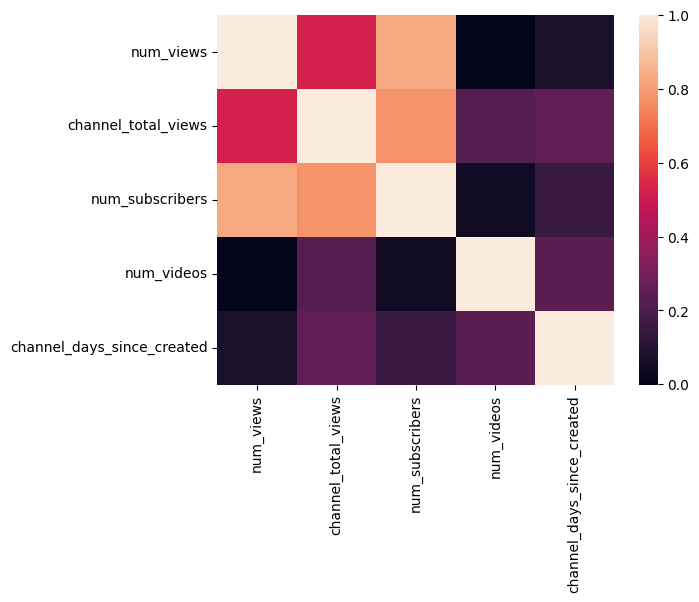

In [277]:
sns.heatmap(oneweek[ch_corr_cols].corr())

Age of the channel and number of uploaded videos do not correlate with views. Number of subscribers strongly correlates with views and total channel views correlated modestly with the number of views a video has 1 week after showing up on most popular.

## Is there a best day of week or time of day to upload?
Judging based off one week performance.

In [279]:
best_upload = pd.concat([oneweek["num_views"], oneweek["video_published_dt"].dt.dayofweek, oneweek["video_published_dt"].dt.hour], axis=1)
best_upload.columns = ["num_views", "published_dayofweek", "published_hourofday"]
best_upload

,num_views,published_dayofweek,published_hourofday
56,10178441,4,13
238,2019230,4,22
420,16876175,4,5
602,904825,4,15
784,3473190,3,15
...,...,...,...
102127,378371,5,22
102254,1106033,5,15
102436,1164978,5,15
102561,767587,2,12


In [280]:
day_dict = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}
best_upload["published_dayofweek"] = best_upload["published_dayofweek"].map(lambda x: day_dict[x])
best_upload

,num_views,published_dayofweek,published_hourofday
56,10178441,Friday,13
238,2019230,Friday,22
420,16876175,Friday,5
602,904825,Friday,15
784,3473190,Thursday,15
...,...,...,...
102127,378371,Saturday,22
102254,1106033,Saturday,15
102436,1164978,Saturday,15
102561,767587,Wednesday,12


### Best day of week to upload

In [281]:
best_dayofweek = best_upload.groupby("published_dayofweek")["num_views"].median().sort_values(ascending=False)
best_dayofweek = best_dayofweek.reset_index()
best_dayofweek.columns = ["dayofweek", "median_views"]
best_dayofweek

,dayofweek,median_views
0,Friday,1626198.5
1,Saturday,1484062.0
2,Thursday,1060178.0
3,Sunday,969323.0
4,Monday,929527.0
5,Tuesday,791703.0
6,Wednesday,756391.5


<Axes: xlabel='dayofweek', ylabel='median_views'>

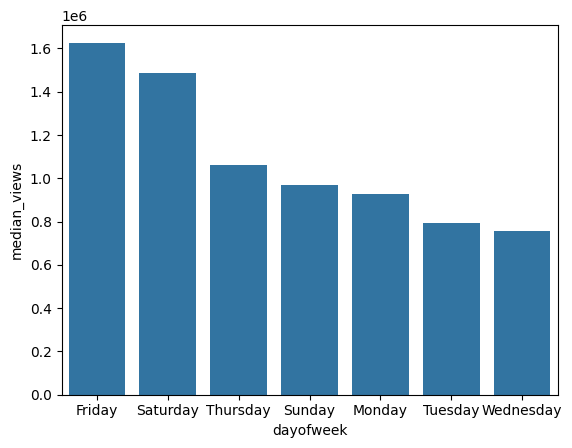

In [282]:
# fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(data=best_dayofweek, x="dayofweek", y="median_views")

Friday and Saturday uploads get the most views. Tuesday and Wednesday uploads get the least.

### Best hour of day to upload

In [283]:
best_hourofday = best_upload.groupby("published_hourofday")["num_views"].median().sort_values(ascending=False)
best_hourofday = best_hourofday.reset_index()
best_hourofday.columns = ["hourofday", "median_views"]
best_hourofday

,hourofday,median_views
0,1,1544372.0
1,19,1430965.0
2,13,1409976.0
3,16,1313427.0
4,8,1283075.0
5,9,1237549.0
6,4,1216592.0
7,5,1184118.5
8,15,1164978.0
9,14,1131380.5


9am, 1am, and 7am have the best performance.

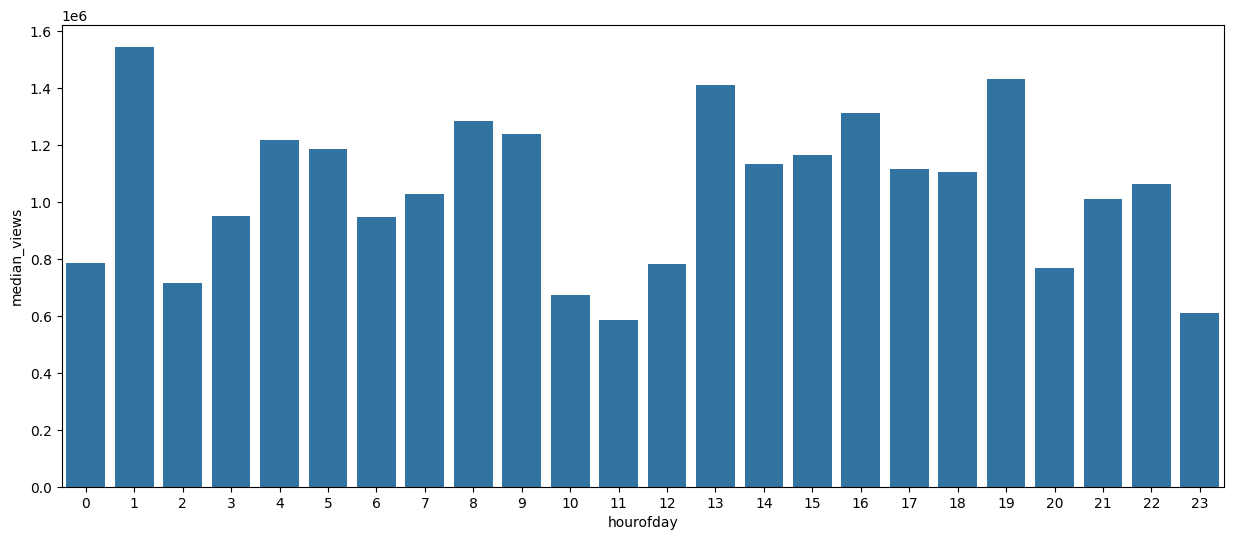

In [284]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(data=best_hourofday, x="hourofday", y="median_views", ax=ax)

# Tableau Preprocessing
Combine first and oneweek into a single dataframe.

In [287]:
first.shape, first.columns

((948, 25),
 Index(['video_collected_dt', 'video_id', 'num_views', 'num_likes',
        'num_comments', 'channel_id', 'video_title', 'video_description',
        'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
        'video_published_dt', 'category_id', 'category_name', 'collected_date',
        'collected_hour', 'channel_collected_dt', 'channel_total_views',
        'num_subscribers', 'num_videos', 'channel_name', 'channel_created_dt',
        'channel_days_since_created', 'hours_since_published'],
       dtype='object'))

In [286]:
oneweek.shape, oneweek.columns

((697, 25),
 Index(['video_collected_dt', 'video_id', 'num_views', 'num_likes',
        'num_comments', 'channel_id', 'video_title', 'video_description',
        'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
        'video_published_dt', 'category_id', 'category_name', 'collected_date',
        'collected_hour', 'channel_collected_dt', 'channel_total_views',
        'num_subscribers', 'num_videos', 'channel_name', 'channel_created_dt',
        'channel_days_since_created', 'hours_since_published'],
       dtype='object'))

In [303]:
merge_cols = ["num_views", "num_likes", "num_comments", "channel_total_views", "num_subscribers", "num_videos"] + ["video_id"]
tableau_df = oneweek.merge(first[merge_cols], on=["video_id"], how="left", suffixes=["_1week", "_1st"])
print(tableau_df.shape)
tableau_df.head()

(697, 31)


,video_collected_dt,video_id,num_views_1week,num_likes_1week,num_comments_1week,channel_id,video_title,video_description,num_tags,duration_seconds,...,channel_name,channel_created_dt,channel_days_since_created,hours_since_published,num_views_1st,num_likes_1st,num_comments_1st,channel_total_views_1st,num_subscribers_1st,num_videos_1st
0,2024-07-27 21:00:05.811850,laNA2HgwYXU,10178441,404423,18802,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,Ryan Reynolds,2015-11-03 22:28:21,3188.938737,8.294107,7023341,334132,16936,828829584,4560000,319
1,2024-07-27 21:00:05.811850,u_as_PygtDc,2019230,70374,6578,UCGTKwjs1ctvgwCRa67RNO-Q,Uh Oh…My Boaterhome Might Actually Be a BUMMER...,Thanks to ARMRA Colostrum for sponsoring this ...,44,1657,...,HeavyDSparks,2015-05-01 22:33:04,3374.935462,7.938875,1022746,46145,4234,876439042,3890000,776
2,2024-07-27 21:00:05.811850,Qn1UJssT-mU,16876175,780063,60523,UCsSsgPaZ2GSmO6il8Cb5iGA,skibidi toilet 76 (part 2),cameramen attempt to escape city\n\nfull-scree...,7,268,...,DaFuq!?Boom!,2016-06-06 15:19:28,2973.236573,8.666479,13106958,716571,57805,17058047576,42900000,299
3,2024-07-27 21:00:05.811850,H-c1bAk9Soc,904825,36447,2624,UCOgGAfSUy5LvEyVS_LF5kdw,Brits try Texas Ballpark food!,"Get 4 months extra on a 2 year plan, plus up t...",63,876,...,JOLLY,2015-10-07 18:25:54,3216.107105,8.228875,535473,25595,1943,1164270894,3980000,836
4,2024-07-27 21:00:05.811850,7Nk5C6o3PkQ,3473190,144126,5234,UCPD_bxCRGpmmeQcbe2kpPaA,Childish Gambino Goes On a Vision Quest While ...,"Donald Glover—a.k.a., Childish Gambino—is a fi...",25,1393,...,First We Feast,2014-02-28 21:48:23,3801.966492,9.249940,2272245,104098,4229,3840733051,13600000,1691


In [304]:
tableau_df.columns

Index(['video_collected_dt', 'video_id', 'num_views_1week', 'num_likes_1week',
       'num_comments_1week', 'channel_id', 'video_title', 'video_description',
       'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
       'video_published_dt', 'category_id', 'category_name', 'collected_date',
       'collected_hour', 'channel_collected_dt', 'channel_total_views_1week',
       'num_subscribers_1week', 'num_videos_1week', 'channel_name',
       'channel_created_dt', 'channel_days_since_created',
       'hours_since_published', 'num_views_1st', 'num_likes_1st',
       'num_comments_1st', 'channel_total_views_1st', 'num_subscribers_1st',
       'num_videos_1st'],
      dtype='object')

In [292]:
tableau_df["video_description"].apply(lambda x: "\n" in x).sum()

0

In [294]:
tableau_df["video_description"].apply(lambda x: "\r" in x).sum()

16

In [299]:
tableau_df["video_description"] = tableau_df["video_description"].apply(lambda x: x.replace("\r", "\\r").replace("\n", "\\n"))

In [300]:
tableau_df.to_csv("tableau_df.csv", index=False)